Imports

In [91]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras import backend as K    
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.decomposition import PCA
import seaborn as sns

In [92]:
def plot_ROC(y_test, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr,tpr) 
    plt.plot([0, 1], [0, 1], linestyle='dashed')
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    title += "\nAUC: " + str(round(auc_val, 4))
    plt.title(title)
    plt.show()

In [98]:
def plot_cm(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)
    cm_df = (cm_df.T/np.sum(cm_df, axis=1)).T
    sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues, fmt=".2%")
    plt.imshow(cm)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

In [94]:
def plot_pr(y_test, y_pred, title):
    new_pred = []
    for val in y_pred:
        if val >= 0.5:
            new_pred.append(val)
        else:
            new_pred.append(0)
    prec, recall, _ = precision_recall_curve(y_test, new_pred)
    plt.plot(recall, prec)
    plt.ylim([0, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title + " Precision vs Recall")

In [95]:
def convert_pred(y_pred, threshold):
    new_pred = np.empty((y_pred.size), dtype='int32')
    for i in range(y_pred.size):
        if y_pred[i] >= threshold:
            new_pred[i] = 1
        else:
            new_pred[i] = 0
    
    return new_pred

# Part 0: Load in pneumonia/healthy data to train CNN on

We will be training a CNN with a large pneumonia/healthy chest x-ray dataset and use transfer learning to train it for COVID/Non-COVID

In [96]:
init_d = {'filename': [], 'target': []}

# format: (file location, healthy/pneumonia(0/1))
files = [('train/Normal', 0), 
         ('train/Pneumonia', 1),
         ('test/Pneumonia', 1),
         ('val/Normal', 0), 
         ('val/Pneumonia', 1),]

for file in files:
    dir_path = os.path.abspath(os.getcwd())
    dir_path = dir_path + "/chest_xray/" + file[0]
    list = os.listdir(dir_path)
    for pic in list:
        if '.DS_Store' not in pic:
            init_d['filename'].append(pic)
            init_d['target'].append(file[1])

# Part 1: Preprocessing for images
Load in images for the corresponding target data with PIL. Reformat all images to the same dimensions and convert them to a numpy array for the models to use (where each is a (# pixels, # pixels) array).

In [97]:
# Load in image data from filenames with PIL
img_dim = 128
def normalize_images(d, curr_dir):
    """normalize all images inside dictionary"""
    images = np.empty((len(d['target']), img_dim, img_dim, 3))

    for i in range(len(d['filename'])):
        image = Image.open(curr_dir + d['filename'][i])

        # resize image shape
        image = image.resize((img_dim, img_dim))

        # convert to grayscale
        image = image.convert('LA')

        images[i] = np.array(image)

    # normalize values
    images = images / 255.0
    return images

In [80]:
# get train/test/val images
images = normalize_images(init_d, "chest_xray/pooled_imgs/")

### Data Augmenation

In [34]:
aug_count = 15
def augment_images(images, targets):
    data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal", dtype='float64'),
      layers.experimental.preprocessing.RandomTranslation(width_factor=0.05, height_factor=0.05, dtype='float64')
    ])
    
    aug_images = np.empty((len(targets) * (aug_count + 1), img_dim, img_dim, 3))
    new_targets = []
    
    
    for i in range(len(targets)):
        image = tf.expand_dims(images[i], 0)
        for j in range(0, aug_count):
            new_image = data_augmentation(image)
            new_targets.append(targets[i])
            aug_images[len(new_targets) - 1] = new_image[0]
        
        # add base image
        new_targets.append(targets[i])
        aug_images[len(new_targets) - 1] = images[i]
    
    return np.asarray(aug_images), new_targets

# Part 2: Train Pneumonia/Healthy Classifier with CNN

In [100]:
# split data
x_train1, x_test1, y_train1, y_test1 = train_test_split(images, init_d["target"], test_size=0.20, random_state=0)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=0.20, random_state=0)
y_train1 = np.asarray(y_train1)
y_val1 = np.asarray(y_val1)
y_test1 = np.asarray(y_test1)

In [ ]:
# build model for convolutional network
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_dim, img_dim, 3), padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))


# add more layers
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(2))

# compile 
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
cnn_model.summary()

In [189]:
# Set up early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        verbose=1
    )
]

history = cnn_model.fit(x_train1, np.asarray(y_train1), epochs=10,
                       validation_data=(x_val1, y_val1),
                       callbacks=callbacks
                       )

Epoch 1/10
113/113 [==============================] - 109s 968ms/step - loss: 0.5699 - accuracy: 0.7531 - val_loss: 0.6952 - val_accuracy: 0.7689
Epoch 2/10
113/113 [==============================] - 106s 941ms/step - loss: 0.3525 - accuracy: 0.8426 - val_loss: 0.1318 - val_accuracy: 0.9522
Epoch 3/10
113/113 [==============================] - 106s 941ms/step - loss: 0.1594 - accuracy: 0.9422 - val_loss: 0.1171 - val_accuracy: 0.9600
Epoch 4/10
113/113 [==============================] - 106s 937ms/step - loss: 0.1256 - accuracy: 0.9508 - val_loss: 0.1034 - val_accuracy: 0.9589
Epoch 5/10
113/113 [==============================] - 106s 942ms/step - loss: 0.1242 - accuracy: 0.9519 - val_loss: 0.1087 - val_accuracy: 0.9633
Epoch 00005: early stopping


In [203]:
# save model
cnn_model.save('basemodel/')

INFO:tensorflow:Assets written to: basemodel/assets


36/36 - 7s - loss: 0.1081 - accuracy: 0.9627


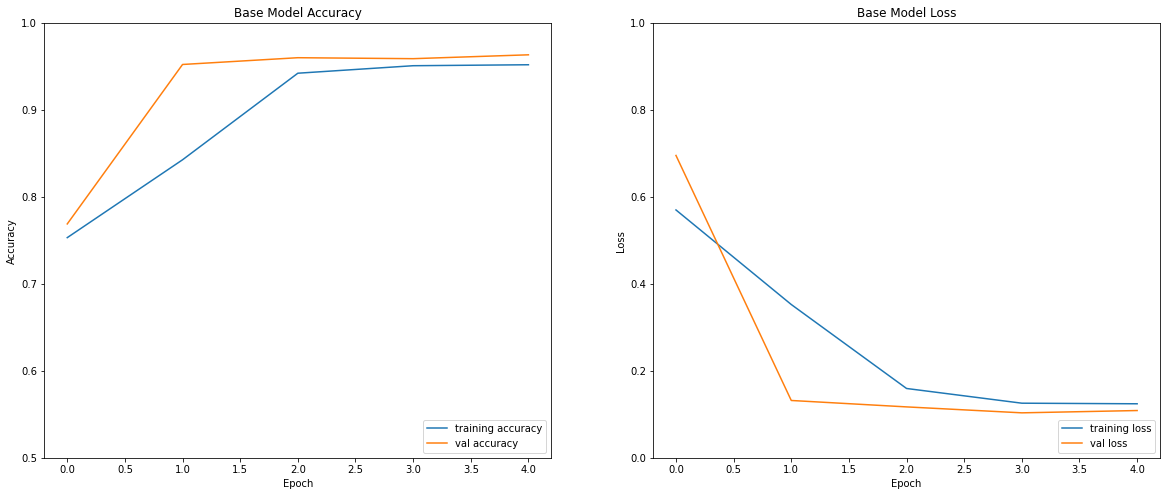

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(history.history['accuracy'], label='training accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'val accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Base Model Accuracy')
axs[0].set_ylim([0.5, 1])
axs[0].legend(loc='lower right')

axs[1].plot(history.history['loss'], label='training loss')
axs[1].plot(history.history['val_loss'], label = 'val loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Base Model Loss')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(x_test1, y_test1, verbose=2)

In [84]:
cnn_model = tf.keras.models.load_model('basemodel/')

In [85]:
phy_pred = cnn_model.predict(x_test1)

In [88]:
phy_pred_norm = np.empty(y_test1.size, dtype='int32')

for i in range(y_test1.size):
    ind = np.argmax(phy_pred[i])
    phy_pred_norm[i] = ind

In [89]:
print(classification_report(y_test1, phy_pred_norm))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       262
           1       0.96      0.99      0.98       863

    accuracy                           0.96      1125
   macro avg       0.97      0.93      0.95      1125
weighted avg       0.96      0.96      0.96      1125



# Part 3: Load in COVID Data

Read in csv of metadata for the images and select target data. For our target data we are selecting COVID/Non-COVID, Survival, Intubation, and Admission to the ICU - resulting in 28 classes where class 0 = Non-COVID and class > 0 is COVID and some unique combination of the classes above. For the initial training and testing of this data, any class > 0 we set to 1 to train a binary classifier for COVID/Non-COVID

In [9]:
data = []
with open("metadata.csv") as file:
    for row in csv.reader(file):
        data.append(row)

data = data[1:]

d = {'filename': [], 'target': []}

for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis = image[4].split("/")
    diagnosis = diagnosis[len(diagnosis) - 1].lower()
    # set target based on meta data
    if diagnosis != "covid-19":
        if diagnosis == "todo":
            # if not classified yet target = -1
            # d['filename'].append(image[23])
            # d['target'].append(-1)
            # ignore unknown data
            continue
        else:
            # if not COVID-19 target = 0
            d['filename'].append(image[23])
            d['target'].append(0)
    else:
        # if it is COVID-19
        d['filename'].append(image[23])
        d['target'].append(1)
        
file.close()

# add normal chest xrays to data
dir_path = os.path.abspath(os.getcwd())
dir_path = dir_path+"/chest_xray/test/Normal"
list = os.listdir(dir_path)
for pic in list:
    d['filename'].append(pic)
    d['target'].append(0)
    
total = [0] * 2

for target in d['target']:
    if target == 0:
        total[0] += 1
    else:
        total[1] += 1
print(total)

[513, 504]


In [10]:
# preprocess covid/noncovid images
covid_images = normalize_images(d, "model_images/")

### Augmentation

# Part 2: Train COVID/Non-COVID with Transfer Learning

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(aug_count + 1):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(covid_images_aug[i], cmap='gray', vmin=0, vmax=255)
  plt.axis("off")

In [55]:
# split data
x_train, x_test, y_train, y_test = train_test_split(covid_images, d["target"], test_size=0.20, random_state=2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=2)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [56]:
# augment the training data
x_train, y_train = augment_images(x_train, y_train.ravel())
print("base image count: ", len(y_train))

base image count:  10400


In [12]:
def build_covid_model(learn_rate=0.01, dropout_rate=0.0, 
                      layers=(128, 128), num_classes=2, decay_rate=0.8, decay_steps=100000):
    base_model = tf.keras.models.load_model('basemodel_aug/')
    covid_model = models.Sequential()

    # add all layers except densely connected to new model
    for layer in base_model.layers[:-2]:
        layer.trainable = False
        covid_model.add(layer)

    # add new dense layers on top of old model
    #covid_model.add(layers.Dense(64, activation='relu'))
    try:
        for neurons in layers:
            covid_model.add(tf.keras.layers.Dense(int(neurons)))
            covid_model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
            covid_model.add(tf.keras.layers.BatchNormalization())
    except:
        covid_model.add(tf.keras.layers.Dense(layers))
        covid_model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        covid_model.add(tf.keras.layers.BatchNormalization())
    
    covid_model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # set new low learning rate for fine-tuning
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learn_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate)

    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    if num_classes == 2:
        covid_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        covid_model.compile(optimizer=opt,
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])
    else:
        covid_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        covid_model.compile(optimizer=opt,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

    return covid_model


In [43]:
# make classifier
covid_test_model = KerasClassifier(
    build_fn = build_covid_model,
    learn_rate = 0.001,
    dropout_rate = 0.6,
    layers=(128, 128, 128),
    num_classes=2,
    decay_rate=0.8,
    decay_steps=100000
)

# random search http://ethen8181.github.io/machine-learning/keras/nn_keras_hyperparameter_tuning.html
learning_rates = [0.001, 0.01, 0.0005, 0.0001]
dropout_rates = [0.2, 0.4, 0.6]
dif_layers = [(64), (64, 64), (128), (32), (128, 128, 128)]
decay_rates = [0.5, 0.7, 0.8, 0.85, 0.65, 0.55]
decay_step = [100000, 10000, 50000, 80000]
distributions = dict(layers=dif_layers, 
                     dropout_rate=dropout_rates, decay_rate=decay_rates, decay_steps=decay_step)

clf = RandomizedSearchCV(covid_test_model, distributions, random_state=0, n_jobs=-1, 
                         scoring="roc_auc", verbose=10, cv=2)
search = clf.fit(covid_images_aug, targets)
search.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  5.7min remaining: 22.8min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  5.7min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  5.8min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:  5.8min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  5.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.1min finished


221/221 [==============================] - 25s 112ms/step - loss: 0.5274 - accuracy: 0.7443


{'layers': (64, 64),
 'dropout_rate': 0.2,
 'decay_steps': 80000,
 'decay_rate': 0.7}

In [103]:
# build
base_model = tf.keras.models.load_model('basemodel/')
covid_model = models.Sequential()

# add all layers except densely connected to new model
for layer in base_model.layers[:-2]:
    layer.trainable = False
    covid_model.add(layer)

covid_model.add(base_model.layers[-2])
covid_model.add(layers.Dropout(0.2))
covid_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=0.001,
decay_steps=80000,
decay_rate=0.7)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

covid_model.compile(optimizer=opt,
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=['accuracy'])

covid_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 128, 128, 32)      608       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)       

In [68]:
# setup early stopping: https://www.tensorflow.org/guide/keras/train_and_evaluate
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=2,
        verbose=1
    )
]

covid_history = covid_model.fit(x_train, np.asarray(y_train), epochs=10,
                               validation_data=(x_val, y_val),
                               callbacks=callbacks,
                                batch_size=16
                               )

Epoch 1/10
650/650 [==============================] - 74s 114ms/step - loss: 0.5038 - accuracy: 0.7737 - val_loss: 0.4859 - val_accuracy: 0.7730
Epoch 2/10
650/650 [==============================] - 73s 113ms/step - loss: 0.3309 - accuracy: 0.8565 - val_loss: 0.4419 - val_accuracy: 0.7791
Epoch 3/10
650/650 [==============================] - 73s 112ms/step - loss: 0.2698 - accuracy: 0.8870 - val_loss: 0.4883 - val_accuracy: 0.7607
Epoch 4/10
650/650 [==============================] - 73s 113ms/step - loss: 0.2156 - accuracy: 0.9144 - val_loss: 0.4551 - val_accuracy: 0.7975
Epoch 00004: early stopping


7/7 - 1s - loss: 0.4271 - accuracy: 0.8186


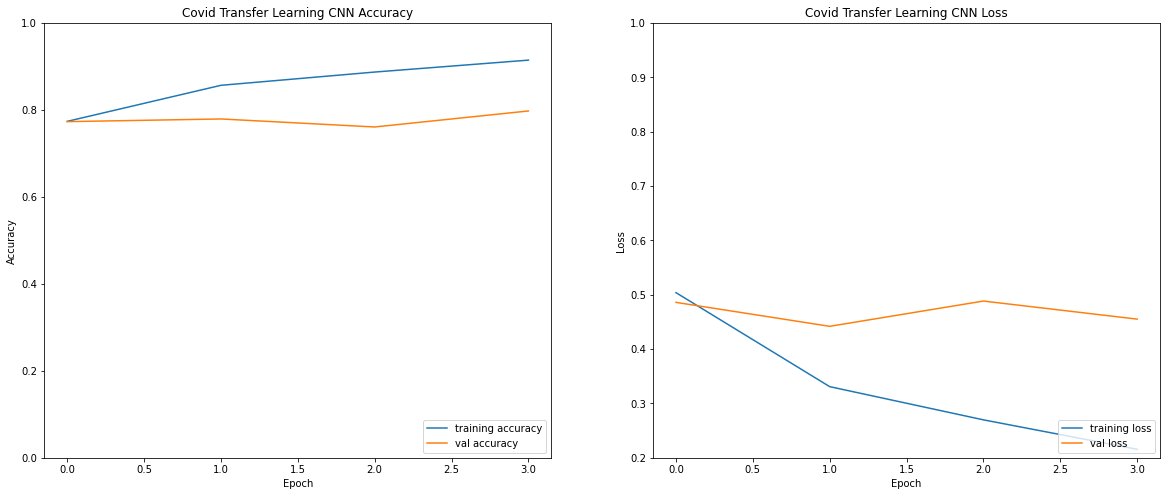

In [69]:
# plot accuracy and loss curves
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(covid_history.history['accuracy'], label='training accuracy')
axs[0].plot(covid_history.history['val_accuracy'], label = 'val accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Covid Transfer Learning CNN Accuracy')
axs[0].set_ylim([0, 1])
axs[0].legend(loc='lower right')

axs[1].plot(covid_history.history['loss'], label='training loss')
axs[1].plot(covid_history.history['val_loss'], label = 'val loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Covid Transfer Learning CNN Loss')
axs[1].set_ylim([0.2, 1])
axs[1].legend(loc='lower right')

test_loss, test_acc = covid_model.evaluate(x_test, y_test, verbose=2)

## Non Augmented Results

In [22]:
cnny_pred = covid_model.predict(x_test)

In [23]:
cnny_pred_norm = convert_pred(cnny_pred, 0.5)

In [26]:
print(classification_report(y_test, cnny_pred_norm))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       112
           1       0.72      0.88      0.79        92

    accuracy                           0.79       204
   macro avg       0.80      0.80      0.79       204
weighted avg       0.81      0.79      0.79       204



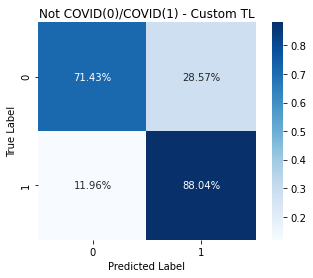

In [101]:
plot_cm(y_test, cnny_pred_norm, "Not COVID(0)/COVID(1) - Custom TL")

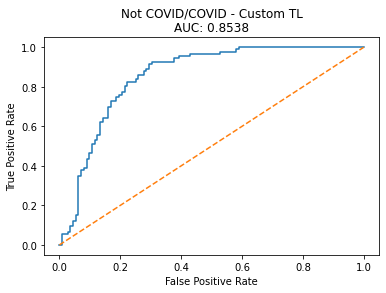

In [31]:
plot_ROC(y_test, cnny_pred, "Not COVID/COVID - Custom TL")

## Augmented Results

In [70]:
cnnay_pred = covid_model.predict(x_test)

In [71]:
cnnay_pred_norm = convert_pred(cnnay_pred, 0.5)

In [72]:
print(classification_report(y_test, cnnay_pred_norm))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       112
           1       0.78      0.84      0.81        92

    accuracy                           0.82       204
   macro avg       0.82      0.82      0.82       204
weighted avg       0.82      0.82      0.82       204



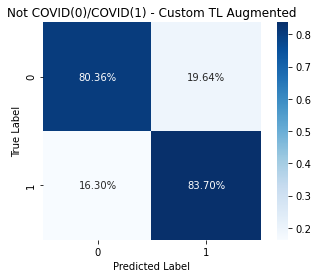

In [102]:
plot_cm(y_test, cnnay_pred_norm, "Not COVID(0)/COVID(1) - Custom TL Augmented")

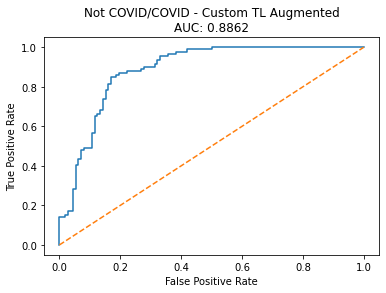

In [51]:
plot_ROC(y_test, cnnay_pred, "Not COVID/COVID - Custom TL Augmented")

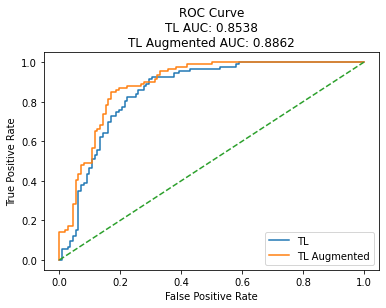

In [53]:
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_test, cnny_pred)
fpr_cnna, tpr_cnna, thresholds = roc_curve(y_test, cnnay_pred)
auc_valcnn = auc(fpr_cnn, tpr_cnn)
auc_valcnna = auc(fpr_cnna, tpr_cnna)
plt.plot(fpr_cnn,tpr_cnn) 
plt.plot(fpr_cnna, tpr_cnna)
plt.plot([0, 1], [0, 1], linestyle='dashed')
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title("ROC Curve\nTL AUC: " + str(round(auc_valcnn, 4)) + "\nTL Augmented AUC: " + str(round(auc_valcnna, 4)))
plt.legend(["TL", "TL Augmented"])
plt.show()